In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.utils import resample, compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential  # Corrected import
from tensorflow.keras.layers import (
    Input, Dense, GRU, GlobalAveragePooling1D, Dropout,
    LayerNormalization, MultiHeadAttention, Layer, Bidirectional, Reshape
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from transformers import BertTokenizer, TFBertModel

from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

from lime.lime_text import LimeTextExplainer

from spektral.layers import GATConv  # For Graph Attention Networks

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# =====================================
# 1. Imports and Setup
# =====================================

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

In [3]:
# =====================================
# 2. Data Loading and Preprocessing
# =====================================

# Read data
df = pd.read_csv("../Cricket - Sheet1.csv")  # Update the path as necessary
df = df[['Text', 'Category', 'Polarity']]

# Initialize Bengali stopwords
stop_words = set(stopwords.words('bengali'))

# Function to clean Bengali text by removing non-Bengali characters, numbers, extra spaces, and stopwords
def clean_text(text):
    if not isinstance(text, str):
        text = ''
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces

    words = text.split()
    # Remove stopwords without lemmatization
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# Function to perform random upsampling
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = [
        resample(
            df[df[target_column] == label],
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        for label in df[target_column].unique()
    ]
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Label Encoding
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])


Category distribution after upsampling:
Category
bowling            2799
batting            2226
team               2094
other              1913
team management    1468
Name: count, dtype: int64

Polarity distribution after upsampling:
Polarity
negative    3500
neutral     3500
positive    3500
Name: count, dtype: int64


In [4]:
# =====================================
# 3. Tokenization and Dataset Preparation
# =====================================

# Initialize tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Train-test split
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Function to compute sample weights
def compute_sample_weights(df):
    # Compute class weights for Category
    class_weights_category = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['Category_encoded']),
        y=df['Category_encoded']
    )
    class_weights_category = dict(enumerate(class_weights_category))

    # Compute class weights for Polarity
    class_weights_polarity = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['Polarity_encoded']),
        y=df['Polarity_encoded']
    )
    class_weights_polarity = dict(enumerate(class_weights_polarity))

    # Compute sample weights as average of category and polarity weights
    weights_category = df['Category_encoded'].map(class_weights_category)
    weights_polarity = df['Polarity_encoded'].map(class_weights_polarity)
    sample_weights = (weights_category + weights_polarity) / 2
    return sample_weights

# Enhanced create_tensor_dataset function with sample weights
def create_tensor_dataset_with_weights(df, batch_size=16, shuffle=True):
    inputs = tokenizer(
        list(df['Text']), 
        padding='max_length', 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    labels_category = tf.convert_to_tensor(df['Category_encoded'].values)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values)
    sample_weights = tf.convert_to_tensor(compute_sample_weights(df).values)

    # Map labels to their respective output names
    labels = {
        'category_output': labels_category,
        'polarity_output': labels_polarity
    }

    dataset = tf.data.Dataset.from_tensor_slices(
        ((input_ids, attention_mask), labels, sample_weights)
    )
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=42)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create datasets with sample weights
train_dataset = create_tensor_dataset_with_weights(train_df)
val_dataset = create_tensor_dataset_with_weights(val_df, shuffle=False)
test_dataset = create_tensor_dataset_with_weights(test_df, shuffle=False)


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

In [ ]:
# =====================================
# 4. Model Definition with Enhancements
# =====================================

# Define Custom GAT Layer using Spektral
class CustomGATLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=4, activation='relu', **kwargs):
        super(CustomGATLayer, self).__init__(**kwargs)
        self.gat = GATConv(channels=units, heads=num_heads, activation=activation)

    def call(self, inputs):
        features, adj = inputs
        return self.gat([features, adj])

# Define Multi-Head Fusion Layer
class MultiHeadFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=4, **kwargs):
        super(MultiHeadFusionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.gru_layers = [GRU(units, return_sequences=True, name=f'gru_{i}') for i in range(num_heads)]
        self.concat = Dense(units, activation='relu', name='fusion_concat')

    def call(self, x):
        fused = [gru(x) for gru in self.gru_layers]
        fused = tf.concat(fused, axis=-1)
        return self.concat(fused)

# Define Custom Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Adversarial Training Callback
class AdversarialTrainingCallback(Callback):
    def __init__(self, epsilon=1e-3):
        super(AdversarialTrainingCallback, self).__init__()
        self.epsilon = epsilon

    def on_train_batch_begin(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and isinstance(layer, Dense):
                perturb = self.epsilon * tf.sign(tf.random.normal(shape=tf.shape(layer.kernel)))
                layer.kernel.assign_add(perturb)

    def on_train_batch_end(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and isinstance(layer, Dense):
                layer.kernel.assign_sub(self.epsilon * tf.sign(tf.random.normal(shape=tf.shape(layer.kernel))))

# Define Multi-Task GNN Model with Enhancements
class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, ff_dim, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.bert = bert_model
        self.transformer_block = TransformerBlock(embed_dim=gnn_units, num_heads=num_heads, ff_dim=ff_dim, rate=0.1)
        self.multi_head_fusion = MultiHeadFusionLayer(gnn_units, num_heads=num_heads)

        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=64)

        # Shared GNN layers
        self.shared_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)

        # Task-specific GNN layers
        self.category_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)
        self.polarity_gnn = CustomGATLayer(units=gnn_units, num_heads=num_heads)

        # Pooling layers
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Output layers
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Feature adjustment
        self.feature_adjustment_layer = Dense(gnn_units, activation='relu')

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        # BERT embeddings
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Feature adjustment
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Additional Transformer Layer
        transformer_output = self.transformer_block(adjusted_features, training=training)

        # Adjacency matrix using Multi-Head Attention
        attention_output = self.multi_head_attention(query=transformer_output, key=transformer_output, value=transformer_output)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)

        # Multi-Head Fusion
        fused_features = self.multi_head_fusion(transformer_output)

        # Residual connection
        fused_features_with_residual = fused_features + transformer_output

        # Shared GNN
        shared_features = self.shared_gnn([fused_features_with_residual, adj_matrix])

        # Category Task
        category_features = self.category_gnn([shared_features, adj_matrix])
        category_features_with_residual = category_features + shared_features

        # Polarity Task
        polarity_features = self.polarity_gnn([shared_features, adj_matrix])
        polarity_features_with_residual = polarity_features + shared_features

        # Pooling
        category_features_pooled = self.category_pooling(category_features_with_residual)
        polarity_features_pooled = self.polarity_pooling(polarity_features_with_residual)

        # Outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

# Define Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Model Parameters
gnn_units = 128
category_output_size = len(category_encoder.classes_)  # Dynamically set based on data
polarity_output_size = len(polarity_encoder.classes_)  # Dynamically set based on data
num_heads = 4
ff_dim = 256  # Feed-forward network dimension for Transformer

# Instantiate Model
multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size,
    ff_dim=ff_dim
)

# Build Model
output_category, output_polarity = multi_task_gnn_model((input_ids, attention_mask))

# Explicitly name the outputs to match the loss and metrics dictionaries
output_category = tf.keras.layers.Lambda(lambda x: x, name='category_output')(output_category)
output_polarity = tf.keras.layers.Lambda(lambda x: x, name='polarity_output')(output_polarity)

model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Display Model Summary
model.summary()

f:\Mini Conda\envs\env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model (MultiTas  ((None, 5),         178927368   ['input_ids[0][0]',              
 kGNNModel)                      (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
 category_output (Lambda)       (None, 5)            0           ['multi_task_gnn_model[0][0]'

In [8]:
# =====================================
# 5. Compilation and Callbacks
# =====================================

# Define Learning Rate Schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile the Model with unique metric names
model.compile(
    optimizer=Adam(
    learning_rate=1e-5,
    clipvalue=1.0
),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'category_output': ['accuracy'],
        'polarity_output': ['accuracy']
    }
)

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-7
)

adversarial_callback = AdversarialTrainingCallback(epsilon=1e-3)


In [9]:
# =====================================
# 6. Training
# =====================================

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr, adversarial_callback]
)


Epoch 1/50
473/473 [==============================] - ETA: 0s - loss: 1.0203 - category_output_loss: 0.6004 - polarity_output_loss: 0.4199 - category_output_accuracy: 0.8311 - polarity_output_accuracy: 0.8745WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: val_loss improved from inf to 0.78987, saving model to best_model.h5
473/473 [==============================] - 259s 500ms/step - loss: 1.0203 - category_output_loss: 0.6004 - polarity_output_loss: 0.4199 - category_output_accuracy: 0.8311 - polarity_output_accuracy: 0.8745 - val_loss: 0.7899 - val_category_output_loss: 0.4735 - val_polarity_output_loss: 0.3164 - val_category_output_accuracy: 0.8631 - val_polarity_output_accuracy: 0.8940 - lr: 1.0000e-05
Epoch 2/50
473/473 [===============

In [10]:
# =====================================
# 7. Evaluation
# =====================================

# Evaluate the model on the test dataset
test_metrics = model.evaluate(test_dataset)
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")

132/132 [==============================] - 21s 161ms/step - loss: 0.3349 - category_output_loss: 0.2395 - polarity_output_loss: 0.0954 - category_output_accuracy: 0.9252 - polarity_output_accuracy: 0.9767
Test Category Loss: 0.2395070344209671, Test Category Accuracy: 0.9252380728721619
Test Polarity Loss: 0.09543845057487488, Test Polarity Accuracy: 0.9766666889190674


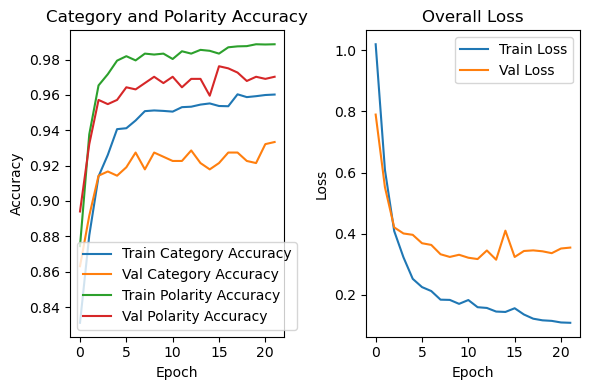

In [12]:
# =====================================
# 8. Visualization of Training Metrics
# =====================================

# Plot training & validation accuracy for Category and Polarity
plt.figure(figsize=(6, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['category_output_accuracy'], label='Train Category Accuracy')
plt.plot(history.history['val_category_output_accuracy'], label='Val Category Accuracy')
plt.plot(history.history['polarity_output_accuracy'], label='Train Polarity Accuracy')
plt.plot(history.history['val_polarity_output_accuracy'], label='Val Polarity Accuracy')
plt.title('Category and Polarity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

# Take a few samples from the test dataset for predictions
for (input_ids, attention_mask), labels_dict, _ in test_dataset.take(5):
    # Get the true labels from labels_dict
    category_labels = labels_dict['category_output']
    polarity_labels = labels_dict['polarity_output']

    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])

    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)

    # Convert the true labels to numpy arrays
    true_category_labels = category_labels.numpy()
    true_polarity_labels = polarity_labels.numpy()

    # Append the true and predicted labels to the lists
    y_true_category.extend(true_category_labels.tolist())
    y_true_polarity.extend(true_polarity_labels.tolist())
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())

    # Display results
    for i in range(len(true_category_labels)):
        true_cat_label = category_encoder.inverse_transform([true_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([true_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]

        print(f"Sample {i+1}:")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()


# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


1/1 [==============================] - 0s 459ms/step
Sample 1:
  True Category: team
  Predicted Category: other
  True Polarity: negative
  Predicted Polarity: negative

Sample 2:
  True Category: other
  Predicted Category: other
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 3:
  True Category: other
  Predicted Category: other
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 4:
  True Category: batting
  Predicted Category: batting
  True Polarity: negative
  Predicted Polarity: negative

Sample 5:
  True Category: team
  Predicted Category: team
  True Polarity: positive
  Predicted Polarity: positive

Sample 6:
  True Category: other
  Predicted Category: other
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 7:
  True Category: other
  Predicted Category: other
  True Polarity: positive
  Predicted Polarity: positive

Sample 8:
  True Category: team management
  Predicted Category: team management
  True Polarity: positive
  Predicted 

In [26]:
import math

batch_size = 16  # You can adjust the batch size as needed

# Ensure test_df indices are reset
test_df = test_df.reset_index(drop=True)

# Initialize empty lists for true and predicted labels
y_true_category, y_true_polarity = [], []
y_pred_category, y_pred_polarity = [], []

num_samples = len(test_df)
num_batches = math.ceil(num_samples / batch_size)

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, num_samples)
    
    # Extract batch data
    batch_texts = test_df['Text'].iloc[start_idx:end_idx].tolist()
    batch_category_labels = test_df['Category_encoded'].iloc[start_idx:end_idx].tolist()
    batch_polarity_labels = test_df['Polarity_encoded'].iloc[start_idx:end_idx].tolist()
    
    # Tokenize batch texts
    inputs = tokenizer(
        batch_texts, 
        padding='max_length', 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Predict using the model
    category_preds, polarity_preds = model.predict([input_ids, attention_mask], verbose=0)
    
    # Convert the predictions to class labels
    category_pred_labels = category_preds.argmax(axis=1)
    polarity_pred_labels = polarity_preds.argmax(axis=1)
    
    # Append true labels and predictions
    y_true_category.extend(batch_category_labels)
    y_true_polarity.extend(batch_polarity_labels)
    y_pred_category.extend(category_pred_labels.tolist())
    y_pred_polarity.extend(polarity_pred_labels.tolist())
    
    # Display results for each sample in the batch
    for i in range(len(batch_texts)):
        true_cat_label = category_encoder.inverse_transform([batch_category_labels[i]])[0]
        pred_cat_label = category_encoder.inverse_transform([category_pred_labels[i]])[0]
        true_pol_label = polarity_encoder.inverse_transform([batch_polarity_labels[i]])[0]
        pred_pol_label = polarity_encoder.inverse_transform([polarity_pred_labels[i]])[0]
        text = batch_texts[i]
        
        print(f"Sample {start_idx + i + 1}:")
        print(f"  Text: {text}")
        print(f"  True Category: {true_cat_label}")
        print(f"  Predicted Category: {pred_cat_label}")
        print(f"  True Polarity: {true_pol_label}")
        print(f"  Predicted Polarity: {pred_pol_label}")
        print()

# Ensure both y_true and y_pred lists have the same length
if len(y_true_category) != len(y_pred_category):
    print(f"Mismatch in lengths: y_true_category={len(y_true_category)}, y_pred_category={len(y_pred_category)}")
if len(y_true_polarity) != len(y_pred_polarity):
    print(f"Mismatch in lengths: y_true_polarity={len(y_true_polarity)}, y_pred_polarity={len(y_pred_polarity)}")

# Generate classification report for both tasks
print("Category Classification Report:")
print(classification_report(y_true_category, y_pred_category, target_names=category_encoder.classes_))

print("\nPolarity Classification Report:")
print(classification_report(y_true_polarity, y_pred_polarity, target_names=polarity_encoder.classes_))

# Calculate macro precision, recall, and F1-score for both tasks
macro_precision_category = precision_score(y_true_category, y_pred_category, average='macro')
macro_recall_category = recall_score(y_true_category, y_pred_category, average='macro')
macro_f1_category = f1_score(y_true_category, y_pred_category, average='macro')

macro_precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
macro_recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
macro_f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Display macro metrics
print(f"\nCategory - Macro Precision: {macro_precision_category:.4f}, Macro Recall: {macro_recall_category:.4f}, Macro F1-score: {macro_f1_category:.4f}")
print(f"Polarity - Macro Precision: {macro_precision_polarity:.4f}, Macro Recall: {macro_recall_polarity:.4f}, Macro F1-score: {macro_f1_polarity:.4f}")


Sample 1:
  Text: অপ্রিয় সত্যি জিম্বাবুয়ে ফেভারিট
  True Category: team
  Predicted Category: other
  True Polarity: negative
  Predicted Polarity: negative

Sample 2:
  Text: আশরাফুল ফিরবে
  True Category: other
  Predicted Category: other
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 3:
  Text: ডিপার্টমেন্টে ভাল খেলবে
  True Category: other
  Predicted Category: other
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 4:
  Text: স্যার লিটন দাসকে টেস্টের নাম্বার ব্যাটিং ঘোষনা হোকআবেদন আইসিসির
  True Category: batting
  Predicted Category: batting
  True Polarity: negative
  Predicted Polarity: negative

Sample 5:
  Text: শ্রীলংকার সাথে টিতে আফিফকে খেলানো
  True Category: team
  Predicted Category: team
  True Polarity: positive
  Predicted Polarity: positive

Sample 6:
  Text: শিরোনামটির সাথে সম্পূর্ণ একমত ভাগ্য সাহসীদের কথাই
  True Category: other
  Predicted Category: other
  True Polarity: neutral
  Predicted Polarity: neutral

Sample 7:
  Text: ভাল উদ্

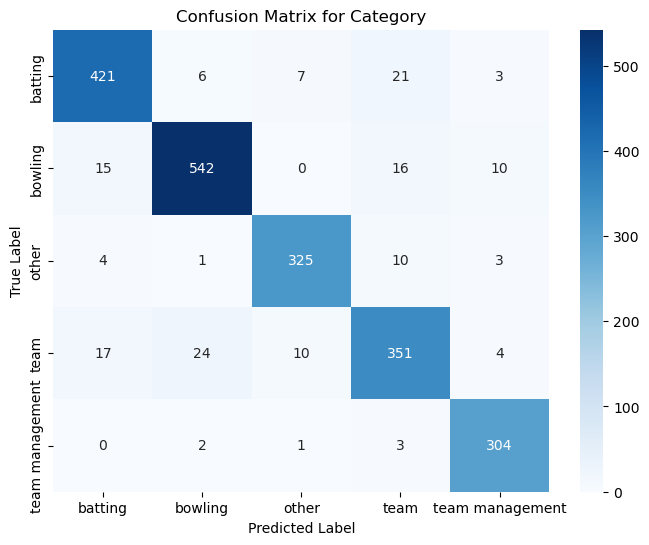

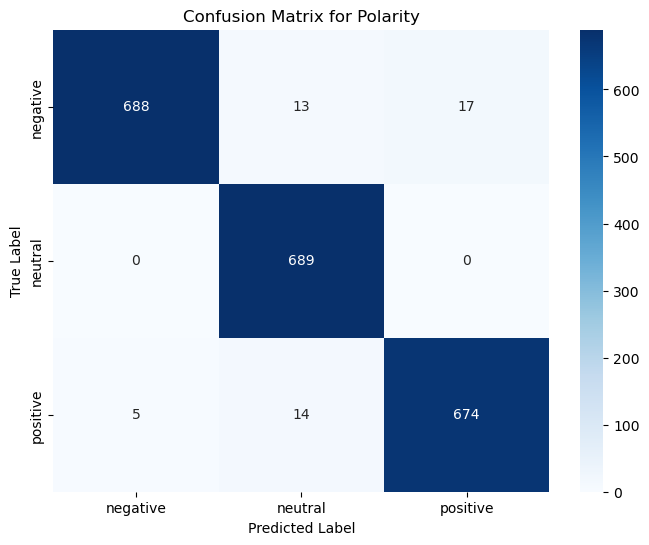

Misclassified Samples for Category:
                                                  Text True_Category  \
0                      অপ্রিয় সত্যি জিম্বাবুয়ে ফেভারিট          team   
17                              রাজ্জাক রাজ্জাকের আসছে       bowling   
64                লেগ ভেল্কির ঔসুধ নাইআফ্রিকার মরন দশা          team   
69                            পিচ চিন্তা খেলা শেখ ভালো         other   
70          শ্রীলংকার স্পিন আক্রমণ বাংলাদেশের চেয়ে ভাল       bowling   
92         রায়নার ভারতের টিমে ভালো ব্যাটসম্যান ধন্যবাদ       batting   
103                          শ্রীলংকা আগের ফ্রম পাচ্ছে          team   
123  ওভারে রানআর ব্যাটিং নেমে ওভার খেয়ে ডাগ মেরে বি...       batting   
141                                  অল আউট হ তারাতারি          team   
151                  অলআউট হও করবা শালারা আবালবাল খেলে          team   

    Predicted_Category  
0                other  
17                team  
64             bowling  
69                team  
70                team  
92                tea

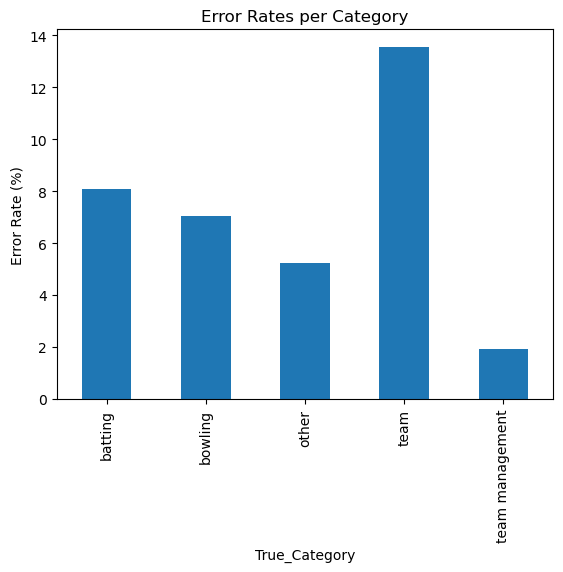

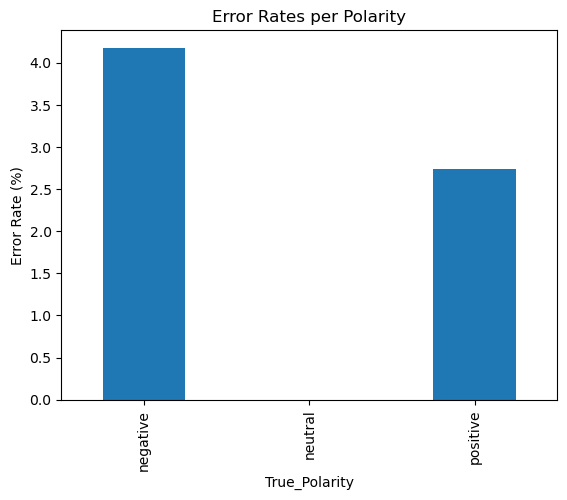

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a DataFrame with texts, true labels, and predicted labels
results_df = test_df.copy()
results_df['True_Category'] = category_encoder.inverse_transform(y_true_category)
results_df['Predicted_Category'] = category_encoder.inverse_transform(y_pred_category)
results_df['True_Polarity'] = polarity_encoder.inverse_transform(y_true_polarity)
results_df['Predicted_Polarity'] = polarity_encoder.inverse_transform(y_pred_polarity)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

# Plot confusion matrix for Category
plot_confusion_matrix(
    y_true_category, y_pred_category, 
    classes=category_encoder.classes_, 
    title='Confusion Matrix for Category'
)

# Plot confusion matrix for Polarity
plot_confusion_matrix(
    y_true_polarity, y_pred_polarity, 
    classes=polarity_encoder.classes_, 
    title='Confusion Matrix for Polarity'
)

# Identify misclassified samples for Category
misclassified_category = results_df[results_df['True_Category'] != results_df['Predicted_Category']]

# Identify misclassified samples for Polarity
misclassified_polarity = results_df[results_df['True_Polarity'] != results_df['Predicted_Polarity']]

# Display some misclassified samples for Category
print("Misclassified Samples for Category:")
print(misclassified_category[['Text', 'True_Category', 'Predicted_Category']].head(10))

# Display some misclassified samples for Polarity
print("\nMisclassified Samples for Polarity:")
print(misclassified_polarity[['Text', 'True_Polarity', 'Predicted_Polarity']].head(10))

# Calculate error rates per class for Category
category_errors = misclassified_category.groupby('True_Category').size()
category_totals = results_df.groupby('True_Category').size()
category_error_rates = (category_errors / category_totals) * 100

print("\nCategory Error Rates (%):")
print(category_error_rates)

# Calculate error rates per class for Polarity
polarity_errors = misclassified_polarity.groupby('True_Polarity').size()
polarity_totals = results_df.groupby('True_Polarity').size()
polarity_error_rates = (polarity_errors / polarity_totals) * 100

print("\nPolarity Error Rates (%):")
print(polarity_error_rates)

# Bar plot of error rates for Category
category_error_rates.plot(kind='bar', title='Error Rates per Category')
plt.ylabel('Error Rate (%)')
plt.show()

# Bar plot of error rates for Polarity
polarity_error_rates.plot(kind='bar', title='Error Rates per Polarity')
plt.ylabel('Error Rate (%)')
plt.show()


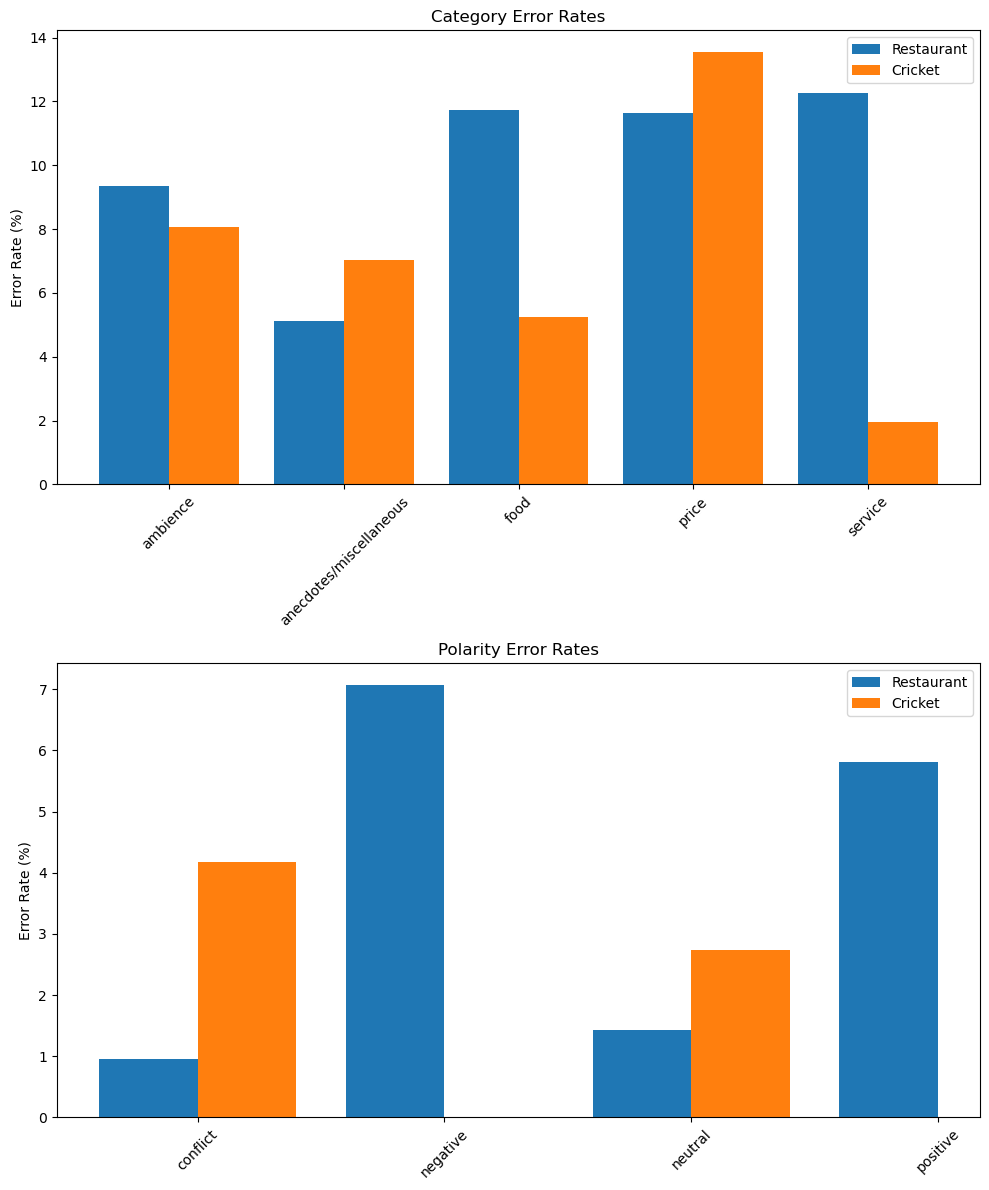

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define datasets dynamically as dictionaries for easy extensibility
datasets = {
    "Restaurant": {
        "categories": ["ambience", "anecdotes/miscellaneous", "food", "price", "service"],
        "category_errors": [9.34, 5.12, 11.74, 11.65, 12.26],
        "polarities": ["conflict", "negative", "neutral", "positive"],
        "polarity_errors": [0.96, 7.07, 1.42, 5.81]
    },
    "Cricket": {
        "categories": ["batting", "bowling", "other", "team", "team management"],
        "category_errors": [8.08, 7.03, 5.25, 13.55, 1.94],
        "polarities": ["negative", "neutral", "positive"],
        "polarity_errors": [4.18, np.nan, 2.74]  # np.nan for missing data
    }
}

# Colors for each dataset
colors = ['tab:blue', 'tab:orange']

# Set up the figure with subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Dynamically plot Category Error Rates
for i, (dataset_name, data) in enumerate(datasets.items()):
    x_positions = np.arange(len(data["categories"])) + (0.4 * i)  # Shifts bars to avoid overlap
    ax[0].bar(x_positions, data["category_errors"], width=0.4, label=dataset_name, color=colors[i], align='center')
ax[0].set_xticks(np.arange(len(datasets["Restaurant"]["categories"])) + 0.2)  # Center tick labels
ax[0].set_xticklabels(datasets["Restaurant"]["categories"], rotation=45)
ax[0].set_title('Category Error Rates')
ax[0].set_ylabel('Error Rate (%)')
ax[0].legend()

# Dynamically plot Polarity Error Rates
for i, (dataset_name, data) in enumerate(datasets.items()):
    x_positions = np.arange(len(data["polarities"])) + (0.4 * i)
    ax[1].bar(x_positions, data["polarity_errors"], width=0.4, label=dataset_name, color=colors[i], align='center')
ax[1].set_xticks(np.arange(len(datasets["Restaurant"]["polarity_errors"])) + 0.2)  # Center tick labels
ax[1].set_xticklabels(datasets["Restaurant"]["polarities"], rotation=45)
ax[1].set_title('Polarity Error Rates')
ax[1].set_ylabel('Error Rate (%)')
ax[1].legend()

# Tight layout for spacing
plt.tight_layout()
plt.show()


C:\Users\mhose\AppData\Local\Temp\ipykernel_7260\908357524.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


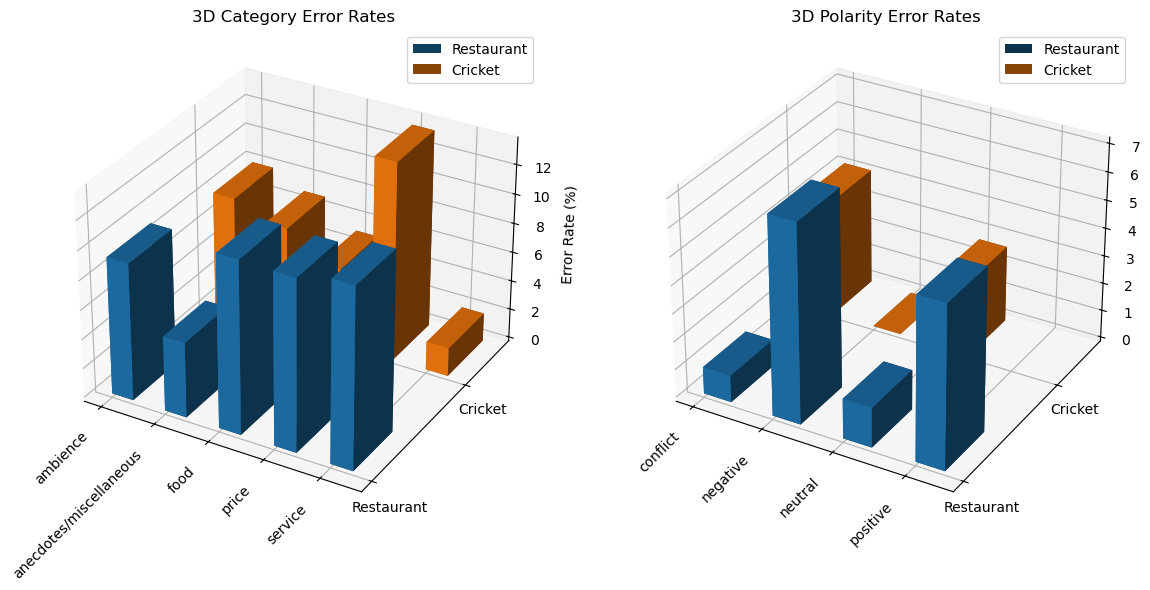

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define datasets dynamically as dictionaries for easy extensibility
datasets = {
    "Restaurant": {
        "categories": ["ambience", "anecdotes/miscellaneous", "food", "price", "service"],
        "category_errors": [9.34, 5.12, 11.74, 11.65, 12.26],
        "polarities": ["conflict", "negative", "neutral", "positive"],
        "polarity_errors": [0.96, 7.07, 1.42, 5.81]
    },
    "Cricket": {
        "categories": ["batting", "bowling", "other", "team", "team management"],
        "category_errors": [8.08, 7.03, 5.25, 13.55, 1.94],
        "polarities": ["negative", "neutral", "positive"],
        "polarity_errors": [4.18, np.nan, 2.74]  # np.nan for missing data
    }
}

# Colors for each dataset
colors = ['tab:blue', 'tab:orange']

# Create 3D figure with two subplots for category and polarity error rates
fig = plt.figure(figsize=(14, 10))

# Plot 3D Category Error Rates
ax1 = fig.add_subplot(121, projection='3d')
for i, (dataset_name, data) in enumerate(datasets.items()):
    x_positions = np.arange(len(data["categories"]))
    y_positions = np.full(len(data["categories"]), i)  # All bars in one dataset are at same y-position
    z_positions = np.zeros(len(data["categories"]))
    dx = dy = 0.4  # Width and depth of the bars
    dz = data["category_errors"]
    ax1.bar3d(x_positions, y_positions, z_positions, dx, dy, dz, color=colors[i], label=dataset_name)

ax1.set_xticks(np.arange(len(datasets["Restaurant"]["categories"])))
ax1.set_xticklabels(datasets["Restaurant"]["categories"], rotation=45, ha='right')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(datasets.keys())
ax1.set_zlabel('Error Rate (%)')
ax1.set_title('3D Category Error Rates')
ax1.legend()

# Plot 3D Polarity Error Rates
ax2 = fig.add_subplot(122, projection='3d')
for i, (dataset_name, data) in enumerate(datasets.items()):
    x_positions = np.arange(len(data["polarities"]))
    y_positions = np.full(len(data["polarities"]), i)
    z_positions = np.zeros(len(data["polarities"]))
    dx = dy = 0.4
    dz = np.nan_to_num(data["polarity_errors"])  # Replace NaN with zero
    ax2.bar3d(x_positions, y_positions, z_positions, dx, dy, dz, color=colors[i], label=dataset_name)

ax2.set_xticks(np.arange(len(datasets["Restaurant"]["polarity_errors"])))
ax2.set_xticklabels(datasets["Restaurant"]["polarities"], rotation=45, ha='right')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(datasets.keys())
ax2.set_zlabel('Error Rate (%)')
ax2.set_title('3D Polarity Error Rates')
ax2.legend()

# Adjust layout for clear viewing
plt.tight_layout()
plt.show()
